# Exploratory data analysis - data set

In this notebook, the explorative data analysis of the data sets arXiv CS and arXiv w/o CS is carried out. The arXiv CS dataset contains all computer science papers within Arxiv. The arXiv w/o CS dataset contains all Arxiv papers that are not in the field of Computer Science.

## Prerequisites

In this section, all the basic requirements are met in order to keep the analyses as compact as possible.
### Loading the packages and defining the visualizations

In [1]:
import os
current_dir = os.getcwd()
if os.path.basename(current_dir) != 'link-prediction-in-graphs':
    parent_dir = os.path.dirname(current_dir)
    os.chdir(parent_dir)
print(f"current working directory: {os.getcwd()}")


import ogb
import sys
sys.path.append('modelling/')
from dataset_split.dataset_loader import PygNodePropPredDataset
from dataset_split.dataset_splitter import Dataset_Splitter

import networkx as nx
import numpy as np
import matplotlib.patches as mpatches
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import random
# import umap
from joblib import dump, load
import gzip
import csv
from networkx.algorithms.community.quality import modularity
from itertools import combinations
from sklearn.manifold import TSNE
from sklearn.cluster import HDBSCAN
import ipywidgets as widgets
from IPython.display import display, clear_output
import gc

# set default plt figsize to (12,6)
plt.rcParams["figure.figsize"] = (12,6)
pd.set_option('display.colheader_justify', 'center')
# Set default font sizes
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['axes.labelsize'] = 18 
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['legend.title_fontsize'] = 18

datasets_eda = ['ogbn-arxiv','ogbn-papers100M','ogbl-ppa']

ds_split = Dataset_Splitter()
dataset = ds_split.load_dataset(datasets_eda[0])
split_edge, edge_index = ds_split.get_edges_split(dataset)

ds_split_2 = Dataset_Splitter()
dataset_2 = ds_split_2.load_dataset(datasets_eda[1])
split_edge_2, edge_index_2 = ds_split_2.get_edges_split(dataset_2)

dataset.name = "arXiv CS"
dataset_2.name = "arXiv w/o CS"

current working directory: /scratch/snx3000/jzwicky/link-prediction-in-graphs
Creating Splits for dataset ogbn-arxiv
Returning Splits for dataset ogbn-arxiv
ogbn-papers100M has been updated.
Creating Splits for dataset ogbn-papers100M
Returning Splits for dataset ogbn-papers100M


### Filter Paper100M
The Paper100M citation network is used for pre-training. In this section, the Paper100M network is filtered so that there is no data leakage and it corresponds to a size for which the computing resources provided are sufficient.

To ensure that there is no data leakage, all computer science papers are deleted, as these could be in the training dataset (ogbn-arxiv). 
In addition, all papers that cannot be assigned to an Arxiv study field are deleted, as data leakage cannot be ruled out for these, and the network then corresponds to a size that was previously defined in the notebook for dataset selection (*dataset_choice.ipynb*).

In [2]:
node_label = np.load('./dataset/ogbn_papers100M_raw/raw/node-label.npz', mmap_mode='r')["node_label"].reshape(-1)
node_label = np.nan_to_num(node_label,nan=-1)

In [17]:
print(f"Number of nodes {len(node_label)}")
print(f"Number of arxiv nodes {len(node_label)- (node_label == -1).sum()}")
print(f"Number of nodes without arxiv category {(node_label == -1).sum()}")

Number of nodes 111059956
Number of arxiv nodes 1546782
Number of nodes without arxiv category 109513174


In [5]:
whole_arxiv = pd.read_csv("./dataset/ogbn_papers100M_raw/mapping/labelidx2arxivcategeory.csv.gz")
filter_list = pd.read_csv("./dataset/ogbn_arxiv/mapping/labelidx2arxivcategeory.csv.gz")["arxiv category"].values

In [21]:
arxiv_wo_cs = whole_arxiv[~whole_arxiv['arxiv category'].isin(filter_list)]
nodes_to_select = np.isin(node_label, arxiv_wo_cs["label idx"].values)

In [24]:
nodes_to_select_in_arxiv = np.isin(node_label, whole_arxiv["label idx"].values)
arxiv_wo_cs = whole_arxiv[~whole_arxiv['arxiv category'].isin(filter_list)]
nodes_to_select = np.isin(node_label, arxiv_wo_cs["label idx"].values)

In [28]:
print(f"Number of arxiv without cs nodes {nodes_to_select.sum()}")
print(f"Number of arxiv cs nodes {nodes_to_select_in_arxiv.sum() -  nodes_to_select.sum()}")

Number of arxiv without cs nodes 1324684
Number of arxiv cs nodes 222098


In [ ]:
np.savez("./dataset/all_arxiv_papers/raw/node-label.npz", 
        node_label=node_label[nodes_to_select]
        )

In [ ]:
with np.load('./dataset/ogbn_papers100M_raw/raw/data.npz', allow_pickle=False, mmap_mode='r') as data:
    node_feat = data['node_feat']    
arxiv_features = node_feat[nodes_to_select]
del node_feat
gc.collect()

16643

In [ ]:
with np.load('./dataset/ogbn_papers100M_raw/raw/data.npz', allow_pickle=False, mmap_mode='r') as data:
    node_year = data['node_year']    
node_year = node_year[nodes_to_select]

In [29]:
with np.load('./dataset/ogbn_papers100M_raw/raw/data.npz', allow_pickle=False, mmap_mode='r') as data:
    edges = data['edge_index']
selected_edges_mask = nodes_to_select[edges[0]] & nodes_to_select[edges[1]]
selected_edges_all_arxiv_mask = nodes_to_select_in_arxiv[edges[0]] & nodes_to_select_in_arxiv[edges[1]]
# edges = edges[:,selected_edges_mask]

In [37]:
n_arxiv_edges = selected_edges_all_arxiv_mask.sum()
n_arxiv_wo_cs_edges = selected_edges_mask.sum()
print(f"Number of edges: {edges.shape[1]}")
print(f"Number of arxiv edges {n_arxiv_edges}")
print(f"Number of edges without arxiv category {edges.shape[1] - n_arxiv_edges}")
print(f"Number of arxiv without cs edges {n_arxiv_wo_cs_edges.sum()}")
print(f"Number of arxiv cs edges {n_arxiv_edges -  n_arxiv_wo_cs_edges}")

Number of edges: 1615685872
Number of arxiv edges 13701428
Number of edges without arxiv category 1601984444
Number of arxiv without cs edges 12823767
Number of arxiv cs edges 877661


In [ ]:
# reset in indices of edges
unique_nodes = np.where(nodes_to_select)[0]
new_indices_map = np.zeros_like(unique_nodes)
new_indices_map[np.argsort(unique_nodes)] = np.arange(unique_nodes.size)
edges_mapped = new_indices_map[np.searchsorted(unique_nodes, edges)]

In [ ]:
np.savez("./dataset/all_arxiv_papers/raw/data.npz", 
        node_feat=arxiv_features,
        edge_index=edges_mapped,
        num_nodes_list=[node_year.shape[0]],
        num_edges_list = [edges.shape[1]],
        node_year=node_year
        )

In [ ]:
test = pd.DataFrame(np.where(node_year >= 2019)[0])
filename = './dataset/all_arxiv_papers/split/time/test.csv.gz'
test.to_csv(filename, index=False, header=False, compression='gzip')

valid = pd.DataFrame(np.where(node_year == 2018)[0])
filename = './dataset/all_arxiv_papers/split/time/valid.csv.gz'
valid.to_csv(filename, index=False, header=False, compression='gzip')

train = pd.DataFrame(np.where(node_year < 2018)[0])
filename = './dataset/ogbn_papers100M/split/time/train.csv.gz'
train.to_csv(filename, index=False, header=False, compression='gzip')

### Helper function

The most important functions have been defined here.

In [3]:
def get_split_edges(graph,train_node_ids,full_graph=False):
    if not full_graph:
        train_node_ids = train_node_ids[0:100]
    edges = np.array([edge for edge in graph["edge_index"].T if (edge[0] in train_node_ids) or (edge[1] in train_node_ids)])
    return edges

def cosine_similarity(v1, v2):
    dot_product = np.dot(v1, v2)
    magnitude_v1 = np.linalg.norm(v1)
    magnitude_v2 = np.linalg.norm(v2)
    return dot_product / (magnitude_v1 * magnitude_v2)

def calc_one_and_two_hops(nx_graph):

    # DG is the directed graph and GWCC is the largest weakly connected component
    GWCC = max(nx.weakly_connected_components(nx_graph), key=len)
    subgraph = nx_graph.subgraph(GWCC)

    # For one-hop reachability, count the neighbors (directly reachable nodes)
    one_hop_counts = {node: len(list(subgraph.successors(node))) for node in subgraph}

    # For two-hop reachability, count unique neighbors of neighbors, excluding self-loops
    two_hop_counts = {}
    for node in subgraph:
        neighbors = set(subgraph.successors(node))
        two_hop_neighbors = set()
        for neighbor in neighbors:
            two_hop_neighbors |= set(subgraph.successors(neighbor))
            
        # Remove the original node to avoid counting self-loops
        two_hop_neighbors.discard(node)
        two_hop_counts[node] = len(two_hop_neighbors)
    return one_hop_counts,two_hop_counts,len(GWCC)

def calc_common_neighbours(nx_graph):
    # Calculate common neighbors for existing (positive) links
    positive_common_neighbors = []
    for (u, v) in nx_graph.edges():
        common = len(set(nx_graph.successors(u)) & set(nx_graph.successors(v)))
        positive_common_neighbors.append(common)
    
    negative_links = []
    negative_common_neighbors = []
    nodes = list(nx_graph.nodes())
    n_links = len(nx_graph.edges())
    while len(negative_links) < n_links:
        # Zufälliges Knotenpaar auswählen
        u, v = random.sample(nodes, 2)
        # Überprüfen, ob zwischen u und v keine Kante existiert
        if not nx_graph.has_edge(u, v):
            negative_links.append((u, v))
            common = len(set(nx_graph.successors(u)) & set(nx_graph.successors(v)))
            negative_common_neighbors.append(common)
    return positive_common_neighbors,negative_common_neighbors

def calc_similarities(graph,nx_graph,edges):
    # Calculate Similarities between all pairs of nodes
    edges = edges.T
    node_similarities = []
    for i in range(len(edges[0])):
        node_similarities.append(
            cosine_similarity(
                graph.x[edges[0][i]],
                graph.x[edges[1][i]]))

    nodes = list(nx_graph.nodes())
    n_links = len(edges[0])
    random_links = np.array(random.choices(nodes, k = n_links * 2)).reshape((2,n_links))

    # Calculate similarities between all pairs of nodes
    node_similarities_random = []
    for i in range(len(random_links[0])):
        node_similarities_random.append(
            cosine_similarity(
                graph.x[random_links[0][i]],
                graph.x[random_links[1][i]]))
    return node_similarities,node_similarities_random
def replace_number(number):
    return f"{number:,}".replace(",", "'")

### Load data sets
The two datasets arxiv CS and arXiv w/o CS are loaded in this section.

In [4]:
# ARXIV DATASET (Finetuning and Test) ###
# # Extract data
graph = dataset[0]

# # get edges of the split
train_nodes = list(range(dataset[0]["num_nodes"]))
train_edges_uncombined = np.stack((split_edge["train"]["source_node"],split_edge["train"]["target_node"]))
valid_edges = np.stack((split_edge["valid"]["source_node"],split_edge["valid"]["target_node"]))
train_edges = np.hstack((train_edges_uncombined,valid_edges))


# graph["node_feat"] = graph["node_feat"][train_nodes]
# graph["node_year"] = graph["node_year"][train_nodes]
# graph["num_nodes"] == len(train_nodes)
# graph["edge_index"] = train_edges

nx_graph = nx.DiGraph()
# add training nodes and their edges to the graph
nx_graph.add_nodes_from(train_nodes)
nx_graph.add_edges_from(train_edges.T)

len(list(nx_graph.nodes()))
len(train_nodes)
# Papers100M DATASET (Pretrain) ###

# Extract data
graph_2 = dataset_2[0]

# get edges of the split
train_nodes_2 = list(range(dataset_2[0]["num_nodes"]))
train_edges_uncombined_2 = np.stack((split_edge_2["train"]["source_node"],split_edge_2["train"]["target_node"]))
valid_edges_2 = np.stack((split_edge_2["valid"]["source_node"],split_edge_2["valid"]["target_node"]))
train_edges_2 = np.hstack((train_edges_uncombined_2,valid_edges_2))


nx_graph_2 = nx.DiGraph()
# add training nodes and their edges to the graph
nx_graph_2.add_nodes_from(train_nodes_2)
nx_graph_2.add_edges_from(train_edges_2.T)

## Analyses
In this section, the most important key figures on both data sets are compared. The objectives are to find possible sources of error for the model training, to gain an insight into the data sets and to show the comparability of the two data sets. The last point is weighted most heavily.

### Degree Distribution

**Explanation:** The in-degree is the number of papers that cite this paper. The out-degree is the number of papers cited by this paper.

**Why was the calculation made:**
For training the models, it is relevant that the initial degree of the individual nodes is not too large (< 50,000 nodes), as the calculations are computationally intensive with demanding O-notations. In addition, the number of papers that influence a citation should be similarly distributed in both data sets. Otherwise the graph structure is different, which in turn makes transferability more difficult.

The indexing is relevant insofar as it recognizes the extent to which there are central papers that influence various other papers.

In [5]:
# Calculate in-degree and out-degree
in_degrees = dict(nx_graph.in_degree()).values()
out_degrees = dict(nx_graph.out_degree()).values()

# Prepare the data for plotting
in_degree_values = sorted(set(in_degrees))
in_degree_hist = [list(in_degrees).count(x) for x in in_degree_values]

out_degree_values = sorted(set(out_degrees))
out_degree_hist = [list(out_degrees).count(x) for x in out_degree_values]


# Calculate in-degree and out-degree for nx_graph_2
in_degrees_2 = dict(nx_graph_2.in_degree()).values()
out_degrees_2 = dict(nx_graph_2.out_degree()).values()

# Prepare the data for plotting for nx_graph
in_degree_values_2 = sorted(set(in_degrees_2))
in_degree_hist_2 = [list(in_degrees_2).count(x) for x in in_degree_values_2]

out_degree_values_2 = sorted(set(out_degrees_2))
out_degree_hist_2 = [list(out_degrees_2).count(x) for x in out_degree_values_2]

total_nodes_1 = sum(in_degree_hist) 
total_nodes_2 = sum(in_degree_hist_2)

in_degree_hist_rel_1 = [x / total_nodes_1 for x in in_degree_hist]
out_degree_hist_rel_1 = [x / total_nodes_1 for x in out_degree_hist]

in_degree_hist_rel_2 = [x / total_nodes_2 for x in in_degree_hist_2]
out_degree_hist_rel_2 = [x / total_nodes_2 for x in out_degree_hist_2]

In [6]:
max(list(out_degrees))

436

In [7]:
max(list(out_degrees_2))

863

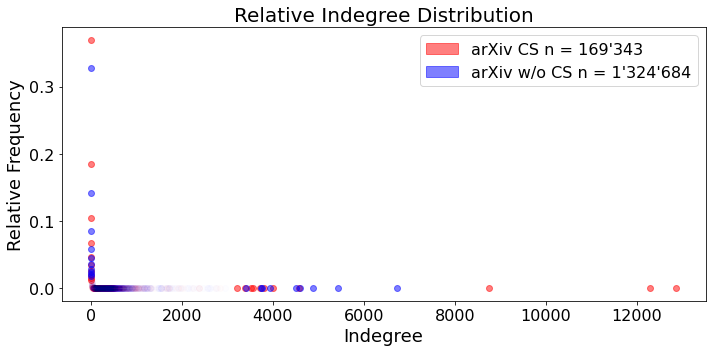

In [42]:
def get_alpha(x, threshold_high=1000, threshold_low=10, low_alpha=0.01, high_alpha=0.5):
    return np.where((x > threshold_high) | (x < threshold_low), high_alpha, low_alpha)

fig, ax = plt.subplots(figsize=(10, 5))

# Calculate alpha values
alpha_1 = get_alpha(np.array(in_degree_values), threshold_high=3000, threshold_low=10, low_alpha=0.01, high_alpha=0.5)
alpha_2 = get_alpha(np.array(in_degree_values_2), threshold_high=3000, threshold_low=10, low_alpha=0.007, high_alpha=0.5)

# Plot with varying alpha values
for x, y, alpha in zip(in_degree_values, in_degree_hist_rel_1, alpha_1):
    ax.plot(x, y, 'ro-', alpha=alpha)
for x, y, alpha in zip(in_degree_values_2, in_degree_hist_rel_2, alpha_2):
    ax.plot(x, y, 'bo-', alpha=alpha)

ax.set_title('Relative Indegree Distribution')
ax.set_xlabel('Indegree')
ax.set_ylabel('Relative Frequency')

# Create custom legend handles
red_patch = mpatches.Patch(color='red', label=f"{dataset.name} n = {replace_number(len(in_degrees))}", alpha=0.5)
blue_patch = mpatches.Patch(color='blue', label=f"{dataset_2.name} n = {replace_number(len(in_degrees_2))}", alpha=0.5)
ax.legend(handles=[red_patch, blue_patch])

plt.tight_layout()
plt.savefig('eda_indegree.pdf', format='pdf',dpi=5000,bbox_inches='tight')
plt.show()

**Observation and interpretation:**
The initial degree of all nodes is less than *50,000*. The distributions are similar in that the frequency for both in-degree and out-degree is highest at the beginning and decreases thereafter. 

However, there are also differences, such as the higher number of output nodes for arXiv w/o CS and at the same time fewer central input nodes. This should be taken into account when analyzing the models. Depending on the requirements, the network for arXiv w/o CS must be adapted to increase the similarity. Nevertheless, it can be assumed that the similarity of the node degrees is sufficient to enable transferability.

### Clustering Coefficients

**Explanation:**
With clustering coefficients, the question arises as to how strongly the neighbors of a node are linked, how strongly clusters are formed in the graph. If all neighbors of a node are linked, the clustering coefficient is **1**, if there are no links, it is **0**. The direction is not taken into account. 

**Why was the calculation made:** The clustering coefficient shows how strong a network of individual nodes is. This is a way of comparing the structure of a network. Ideally, the two networks should have a similar distribution of clustering coefficients.

In [9]:
clustering_coefficients_1 = [v for (k,v) in nx.clustering(nx_graph,nx_graph.nodes()).items()]
clustering_coefficients_2 = [v for (k,v) in nx.clustering(nx_graph_2,nx_graph_2.nodes()).items()]

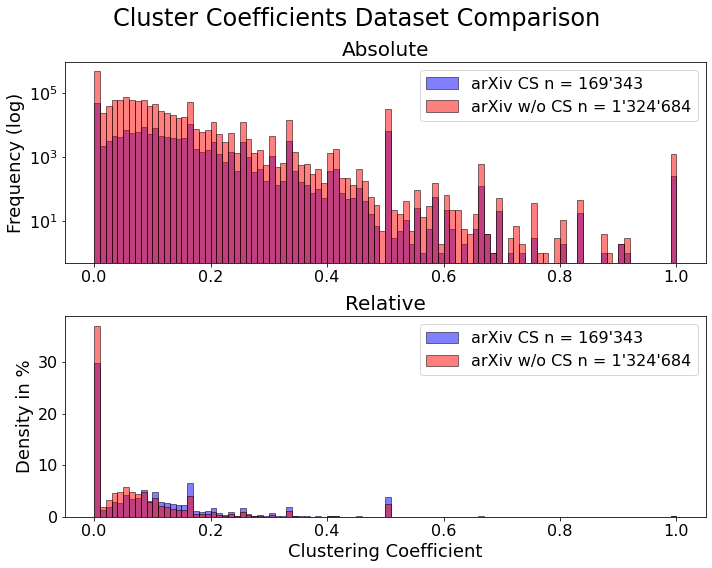

In [44]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=False)

binwidth = 0.01
plt.suptitle("Cluster Coefficients Dataset Comparison",fontsize= 24)
sns.histplot(clustering_coefficients_1, color="blue", label=f'{dataset.name} n = {replace_number(len(clustering_coefficients_1))}', binwidth=binwidth, ax=axs[0], alpha=0.5)
sns.histplot(clustering_coefficients_2, color="red", label=f'{dataset_2.name} n = {replace_number(len(clustering_coefficients_2))}', binwidth=binwidth, ax=axs[0], alpha=0.5)
axs[0].set_title('Absolute')
axs[0].set_ylabel('Frequency (log)')
axs[0].set_yscale("log")
axs[0].legend()

sns.histplot(clustering_coefficients_1, color="blue", label=f'{dataset.name} n = {replace_number(len(clustering_coefficients_1))}', binwidth=binwidth, ax=axs[1], stat='density', alpha=0.5)
sns.histplot(clustering_coefficients_2, color="red", label=f'{dataset_2.name} n = {replace_number(len(clustering_coefficients_2))}', binwidth=binwidth, ax=axs[1], stat='density', alpha=0.5)
axs[1].set_title('Relative')
axs[1].set_xlabel('Clustering Coefficient')
axs[1].set_ylabel('Density in %')
axs[1].legend()

plt.tight_layout()
plt.savefig('eda_clustering_coefficient.pdf', format='pdf',dpi=5000,bbox_inches='tight')
plt.show()


In [11]:
print(f"Durchschnittlicher Clustering Coefficient arXiv CS {round(nx.average_clustering(nx_graph,nx_graph.nodes()),4)}")

print(f"Durchschnittlicher Clustering Coefficient Arxiv ohne Computer Science {round(nx.average_clustering(nx_graph_2,nx_graph_2.nodes()),4)}")

Durchschnittlicher Clustering Coefficient arXiv CS 0.1075
Durchschnittlicher Clustering Coefficient Arxiv ohne Computer Science 0.0754


**Observation and interpretation:** Most cluster coefficients are less than or equal to **0.5** for both datasets. However, the arXiv CS dataset has larger cluster coefficient values, which can also be shown by the higher average values.

The differences in the datasets could be due to the fact that all links (citations) going from Computer Science to another field were deleted. If pre-training does not achieve "sufficient" results, this could be investigated in more detail. It may also be possible to use the individual fields (e.g. mathematics, economics and physics) in separate networks for pre-training (delete edges in the same style).

### Connected Components

**Explanation:** 
With strongly connected components, all nodes can be reached from all nodes (along the link direction). For weakly connected components, the direction of the edge does not matter, there must simply be a connection between all nodes to all nodes.

**Why was the calculation made:** On the one hand, it can be recognized whether and how many nodes are isolated. If this is very different for the two networks, some of them could be deleted. On the other hand, it is interesting to see whether the graph has a relatively similar number of strongly connected components. This shows how many bilateral edges or circular references are present. This results in a further assessment of the graph structure, which should be similar.

If there are several separate weakly connected components, this indicates that they do not interact with most of the network. If there are significantly more of these sub-networks in the arXiv w/o CS, it might be a possibility to delete them.

In [12]:
strong_component_sizes_out = [len(c) for c in nx.strongly_connected_components(nx_graph)]
weak_component_sizes_out = [len(c) for c in nx.weakly_connected_components(nx_graph)]

weak_component_sizes = np.array(weak_component_sizes_out)
print(f"Grösster schwach verbundener Komponent Arxiv CS {weak_component_sizes[weak_component_sizes>50]}")
weak_component_sizes = weak_component_sizes[weak_component_sizes<50]

strong_component_sizes = np.array(strong_component_sizes_out)
print(f"Grösster stark verbundener Komponent Arxiv CS {strong_component_sizes[strong_component_sizes>200]}")
strong_component_sizes = strong_component_sizes[strong_component_sizes < 200]

Grösster schwach verbundener Komponent Arxiv CS [168687]
Grösster stark verbundener Komponent Arxiv CS [21257]


In [13]:
strong_component_sizes_out_2 = [len(c) for c in nx.strongly_connected_components(nx_graph_2)]
weak_component_sizes_out_2 = [len(c) for c in nx.weakly_connected_components(nx_graph_2)]

weak_component_sizes_2 = np.array(weak_component_sizes_out_2)
print(f"Grösster schwach verbundener Komponent Arxiv w/o CS {weak_component_sizes_2[weak_component_sizes_2>90]}")
weak_component_sizes_2 = weak_component_sizes_2[weak_component_sizes_2<50]


strong_component_sizes_2 = np.array(strong_component_sizes_out_2)
print(f"Grösster stark verbundener Komponent Arxiv w/o CS {strong_component_sizes_2[strong_component_sizes_2>200]}")
strong_component_sizes_2 = strong_component_sizes_2[strong_component_sizes_2 < 200]

Grösster schwach verbundener Komponent Arxiv w/o CS [1113981]
Grösster stark verbundener Komponent Arxiv w/o CS [332616]


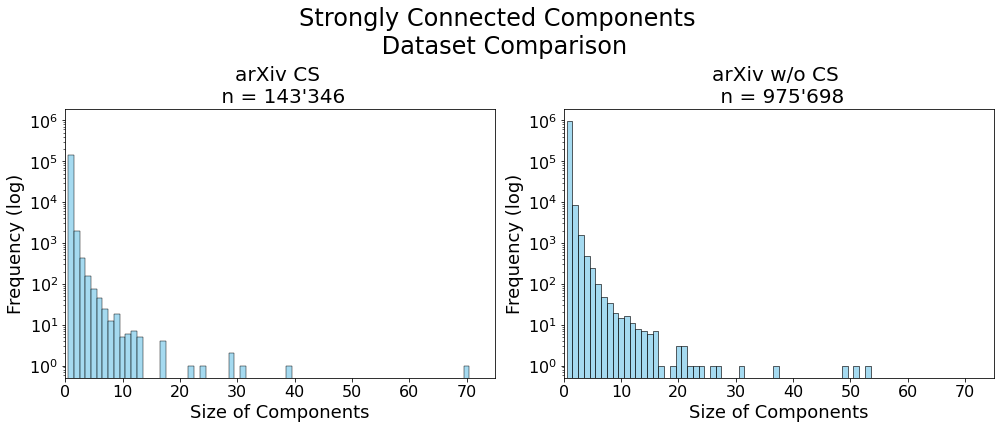

In [94]:
plt.figure(figsize=(14, 10))
plt.suptitle("Strongly Connected Components \n Dataset Comparison",fontsize =24)

ax = plt.subplot(2, 2, 1)
sns.histplot(strong_component_sizes, bins=np.array(range(1, max(strong_component_sizes)+2))-0.5, color='skyblue', kde=False)
plt.title(f'{dataset.name} \n n = {replace_number(len(strong_component_sizes)+1)}')
plt.xlabel('Size of Components')
plt.yscale("log")
plt.ylabel('Frequency (log)')
plt.xticks(range(0, max(strong_component_sizes)+1, 10))
plt.xlim(0,75)


plt.subplot(2, 2, 2,sharey =ax)
sns.histplot(strong_component_sizes_2, bins=np.array(range(1, max(strong_component_sizes_2)+2))-0.5, color='skyblue', kde=False)
plt.title(f'{dataset_2.name} \n n = {replace_number(len(strong_component_sizes_2)+1)}')
plt.xlabel('Size of Components')
plt.ylabel('Frequency (log)')
plt.yscale("log")
plt.xlim(0,75)

plt.xticks(range(0, max(strong_component_sizes)+1, 10))
plt.tight_layout()
plt.savefig('eda_strong_connected.pdf', format='pdf',dpi=5000,bbox_inches='tight')

plt.show()

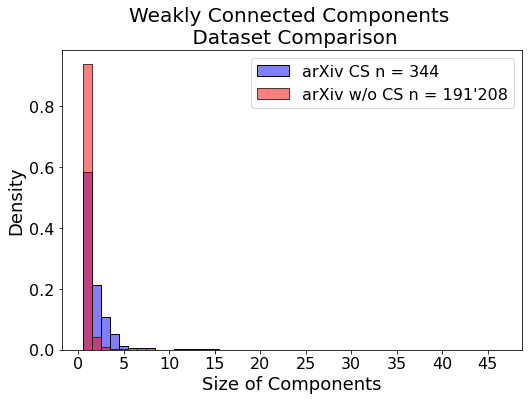

In [47]:
plt.figure(figsize=(14, 10))

# Combined plot
plt.subplot(2, 2, 3)
sns.histplot(weak_component_sizes, bins=np.array(range(1, max(weak_component_sizes) + 2)) - 0.5, color='blue', kde=False, stat='density', label=f"{dataset.name} n = {replace_number(len(weak_component_sizes)+1)}", alpha=0.5)
sns.histplot(weak_component_sizes_2, bins=np.array(range(1, max(weak_component_sizes_2) + 2)) - 0.5, color='red', kde=False, stat='density', label=f"{dataset_2.name} n = {replace_number(len(weak_component_sizes_2)+1)}", alpha=0.5)
plt.title(f'Weakly Connected Components \n Dataset Comparison')
plt.xlabel('Size of Components')
plt.ylabel('Density')
plt.xticks(range(0, 46, 5))
plt.legend()

plt.tight_layout()
plt.savefig('eda_weakly_connected.pdf', format='pdf',dpi=5000,bbox_inches='tight')

plt.show()

In [16]:
print(f"Arxiv CS: Anteil schwach verbundener Komponenten, welche nicht im grössten Komponenten sind: {round(weak_component_sizes.sum()/np.array(weak_component_sizes_out).sum() *100,3)} %")
print(f"Arxiv w/o CS: Anteil schwach verbundener Komponenten, welche nicht im grössten Komponenten sind: {round(weak_component_sizes_2.sum()/ np.array(weak_component_sizes_out_2).sum() * 100,3)} %")

Arxiv CS: Anteil schwach verbundener Komponenten, welche nicht im grössten Komponenten sind: 0.387 %
Arxiv w/o CS: Anteil schwach verbundener Komponenten, welche nicht im grössten Komponenten sind: 15.901 %


In [17]:
print(f"Arxiv CS: Anteil Knoten, welche sich in einem Stark verbundenen Komponenten befindet: {round(len(strong_component_sizes[strong_component_sizes ==1]) / np.array(strong_component_sizes_out).sum() *100,3)} %")
print(f"Arxiv w/o CS: Anteil Knoten, welche sich in einem Stark verbundenen Komponenten befindet: {round(len(strong_component_sizes_2[strong_component_sizes_2 ==1]) / np.array(strong_component_sizes_out_2).sum() * 100,3)} %")

Arxiv CS: Anteil Knoten, welche sich in einem Stark verbundenen Komponenten befindet: 83.012 %
Arxiv w/o CS: Anteil Knoten, welche sich in einem Stark verbundenen Komponenten befindet: 72.829 %


**Observation and interpretation:** What is relevant for the interpretation is that the largest component has been deleted for all visualizations. At arXiv CS there are additionally:
- Largest weak components with 116'051 nodes
- Largest strong components with 13,437 nodes
For arXiv w/o CS there are additionally:
- Largest weak components with 892'314 nodes
- Largest strong components with 261'307 nodes

A first important finding is that the proportion of weakly connected components, which are not in the largest components, is significantly larger in arXiv w/o CS. This can be explained by the approximately 161,000 papers that are both uncited and uncited. As these make no difference for the training, they are kept in the dataset as they could play a role for the evaluation part. If computing resources become scarce, it could be an option to delete these nodes.

There are bilateral edges or circular references in both datasets, as can be seen from the strongly connected components. How these are distributed would have to be investigated in more detail in a further step.

In the case of arXiv CS, the proportion of nodes that are not located in a strongly connected component is greater. Otherwise, there are various strongly connected components in both data sets up to component size **20**. After that, only individual components are present.


### Accessibility

**Explanation:** 
This section examines how much of the graph can be reached when starting from a node. This means in absolute numbers, how many nodes could be reached with one step (all neighbors) and with 2 steps (neighbors of neighbors).

**Why was the calculation made:**
If most of the network can be reached with 2 steps, a 2-layer GNN makes little sense, as many links contain the same basic information. Thus, a first plausibility check of the structure of the GNN is made here. In addition, the distribution of the absolute nodes reached makes it possible to compare how strong the network is.

In [18]:
def calc_one_two_three_hops(nx_graph):
    GWCC = max(nx.weakly_connected_components(nx_graph), key=len)
    subgraph = nx_graph.subgraph(GWCC)
    one_hop_counts = {node: len(list(subgraph.successors(node))) for node in subgraph}

    two_hop_counts = {}
    three_hop_counts = {}
    for node in subgraph:
        neighbors = set(subgraph.successors(node))
        two_hop_neighbors = set()
        three_hop_neighbors = set()

        for neighbor in neighbors:
            two_hop = set(subgraph.successors(neighbor))
            two_hop_neighbors |= two_hop

            for second_neighbor in two_hop:
                three_hop_neighbors |= set(subgraph.successors(second_neighbor))
        
        two_hop_neighbors.discard(node)
        three_hop_neighbors.discard(node)

        two_hop_counts[node] = len(two_hop_neighbors)
        three_hop_counts[node] = len(three_hop_neighbors)
    
    return one_hop_counts, two_hop_counts, three_hop_counts, len(GWCC)


In [19]:
one_hop_counts,two_hop_counts,three_hop_counts, length_gwcc = calc_one_two_three_hops(nx_graph)
one_hop_counts_2,two_hop_counts_2,three_hop_counts2, length_gwcc_2 = calc_one_two_three_hops(nx_graph_2)

In [36]:
np.percentile(np.array(list(one_hop_counts.values())),95)

24.0

In [41]:
np.percentile(np.array(list(two_hop_counts.values())),99)

353.0

In [34]:
np.array(list(three_hop_counts.values())).mean()

184.6922940119867

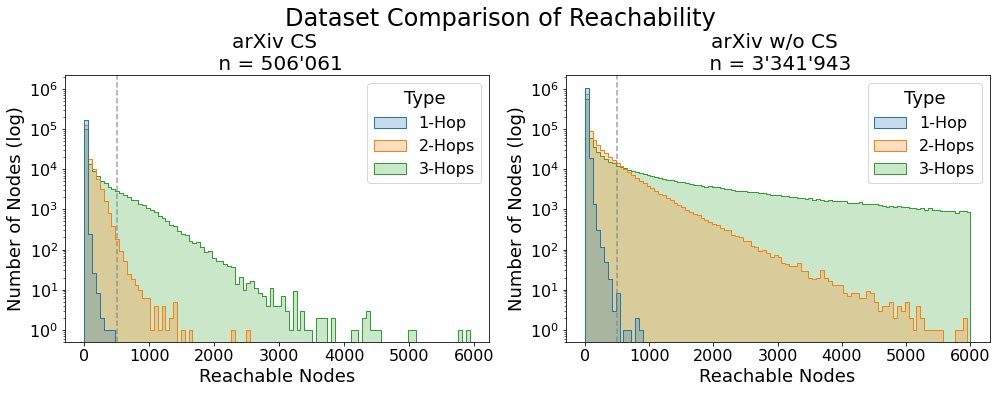

In [83]:
df1 = pd.DataFrame({
    'Percentage of Nodes Reachable': np.array(list(one_hop_counts.values())) / (length_gwcc - 1) * 100,
    'Absolute Nodes Reachable': np.array(list(one_hop_counts.values())),
    'Type': '1-Hop',
    'Graph': 'Graph 1'
})
df2 = pd.DataFrame({
    'Percentage of Nodes Reachable': np.array(list(two_hop_counts.values())) / (length_gwcc - 1) * 100,
    'Absolute Nodes Reachable': np.array(list(two_hop_counts.values())),
    'Type': '2-Hops',
    'Graph': 'Graph 1'
})
df3 = pd.DataFrame({
    'Percentage of Nodes Reachable': np.array(list(one_hop_counts_2.values())) / (length_gwcc_2 - 1) * 100,
    'Absolute Nodes Reachable': np.array(list(one_hop_counts_2.values())),
    'Type': '1-Hop',
    'Graph': 'Graph 2'
})
df4 = pd.DataFrame({
    'Percentage of Nodes Reachable': np.array(list(two_hop_counts_2.values())) / (length_gwcc_2 - 1) * 100,
    'Absolute Nodes Reachable': np.array(list(two_hop_counts_2.values())),
    'Type': '2-Hops',
    'Graph': 'Graph 2'
})

df5 = pd.DataFrame({
    'Percentage of Nodes Reachable': np.array(list(three_hop_counts.values())) / (length_gwcc - 1) * 100,
    'Absolute Nodes Reachable': np.array(list(three_hop_counts.values())),
    'Type': '3-Hops',
    'Graph': 'Graph 1'
})
df6 = pd.DataFrame({
    'Percentage of Nodes Reachable': np.array(list(three_hop_counts2.values())) / (length_gwcc_2 - 1) * 100,
    'Absolute Nodes Reachable': np.array(list(three_hop_counts2.values())),
    'Type': '3-Hops',
    'Graph': 'Graph 2'
})

df_reachability = pd.concat([df1, df2, df3, df4, df5, df6])

plt.figure(figsize=(14, 14))
plt.suptitle("Dataset Comparison of Reachability",fontsize =24)



# Plot for Graph 1 - absolute values
ax0 = plt.subplot(3, 2, 1)
sns.histplot(data=df_reachability[df_reachability['Graph'] == 'Graph 1'], x='Absolute Nodes Reachable', hue='Type', element='step', stat='count', common_bins=True, bins=100)
plt.title(f"{dataset.name} \n n = {replace_number(len(df_reachability[df_reachability['Graph'] == 'Graph 1']))}")
plt.ylabel('Number of Nodes (log)')
plt.axvline(500,color = "gray", alpha =0.7,linestyle= "dashed",label = "Threshold")
plt.yscale("log")
plt.xlabel("Reachable Nodes")



# Plot for Graph 2 - absolute values
ax1 = plt.subplot(3, 2, 2,sharey = ax0)
ax1.axvline(500,color = "gray", alpha =0.7,linestyle= "dashed",label = "Threshold")
sns.histplot(data=df_reachability[df_reachability['Graph'] == 'Graph 2'][df_reachability[df_reachability['Graph'] == 'Graph 2']["Absolute Nodes Reachable"] <6000], x='Absolute Nodes Reachable', hue='Type', element='step', stat='count', common_bins=True, bins=100)
plt.title(f"{dataset_2.name} \n n = {replace_number(len(df_reachability[df_reachability['Graph'] == 'Graph 2']))}")
plt.ylabel('Number of Nodes (log)')
plt.yscale("log")
plt.xlabel("Reachable Nodes")
plt.tight_layout()
plt.savefig('eda_reachability.pdf', format='pdf',dpi= 5000,bbox_inches='tight')
plt.show()

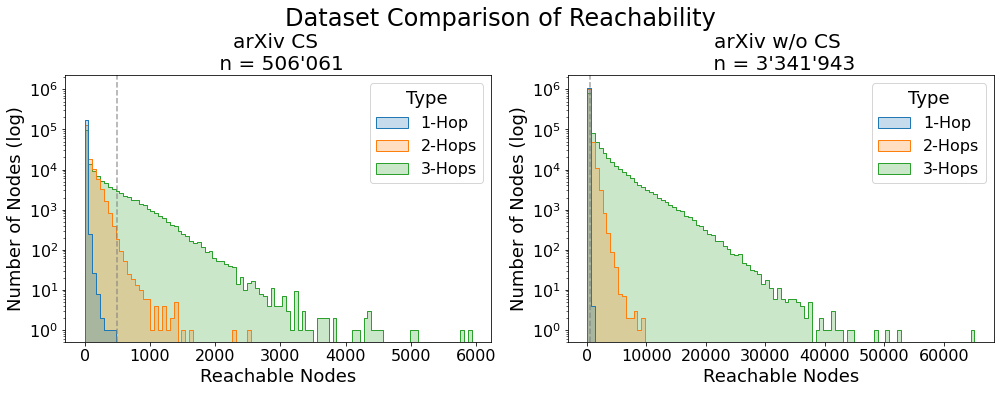

In [90]:
plt.figure(figsize=(14, 14))
plt.suptitle("Dataset Comparison of Reachability",fontsize =24)



# Plot for Graph 1 - absolute values
ax0 = plt.subplot(3, 2, 1)
sns.histplot(data=df_reachability[df_reachability['Graph'] == 'Graph 1'], x='Absolute Nodes Reachable', hue='Type', element='step', stat='count', common_bins=True, bins=100)
plt.title(f"{dataset.name} \n n = {replace_number(len(df_reachability[df_reachability['Graph'] == 'Graph 1']))}")
plt.ylabel('Number of Nodes (log)')
plt.axvline(500,color = "gray", alpha =0.7,linestyle= "dashed",label = "Threshold")
plt.yscale("log")
plt.xlabel("Reachable Nodes")



# Plot for Graph 2 - absolute values
ax1 = plt.subplot(3, 2, 2,sharey = ax0)
ax1.axvline(500,color = "gray", alpha =0.7,linestyle= "dashed",label = "Threshold")
sns.histplot(data=df_reachability[df_reachability['Graph'] == 'Graph 2'], x='Absolute Nodes Reachable', hue='Type', element='step', stat='count', common_bins=True, bins=100)
plt.title(f"{dataset_2.name} \n n = {replace_number(len(df_reachability[df_reachability['Graph'] == 'Graph 2']))}")
plt.ylabel('Number of Nodes (log)')
plt.yscale("log")
plt.xlabel("Reachable Nodes")
plt.tight_layout()
plt.savefig('eda_reachability_full.pdf', format='pdf',dpi= 5000,bbox_inches='tight')
plt.show()

In [21]:
print(f"Arxiv CS durchschnittliche Anzahl Nodes mit 2-Hops erreichbar: {round(np.array(list(two_hop_counts.values())).mean(),1)}")
print(f"Arxiv wo CS durchschnittliche Anzahl Nodes mit 2-Hops erreichbar: {round(np.array(list(two_hop_counts_2.values())).mean(),1)}")

Arxiv CS durchschnittliche Anzahl Nodes mit 2-Hops erreichbar: 46.4
Arxiv wo CS durchschnittliche Anzahl Nodes mit 2-Hops erreichbar: 138.0


**Observation and interpretation:** The proportion of reached nodes ranges up to **2.3 %** for arXiv CS. This percentage is not a problem for the calculation using GNN and a 2-layer GNN can be used. If only the neighbors are selected (1-hop), significantly fewer nodes are reached, which shows the necessity of using a 2nd layer.

Comparing the two datasets, using 2-hops in the arXiv w/o CS, more nodes are reached at maximum (2550 compared to 14'000).
This could be partly due to the fact that links (citations) to other fields were deleted. Nevertheless, the discrepancy cannot be fully explained.

### Common Neighbor Distribution

**Explanation:** 
Common Neighbor indicates how many common neighbors two nodes have. Only the papers that were cited by the papers are taken into account, i.e. along the edge direction. Edges that actually exist are compared with edges that were selected at random and do not exist.

**Why was the calculation made:**
If the distributions of random edges were very similar to the edges, the baseline model with the common neighbor algorithm would be superfluous. The aim is to check whether the baseline model could make sense.

In [22]:
positive_common_neighbors, negative_common_neighbors = calc_common_neighbours(nx_graph)
positive_common_neighbors_2, negative_common_neighbors_2 = calc_common_neighbours(nx_graph_2)

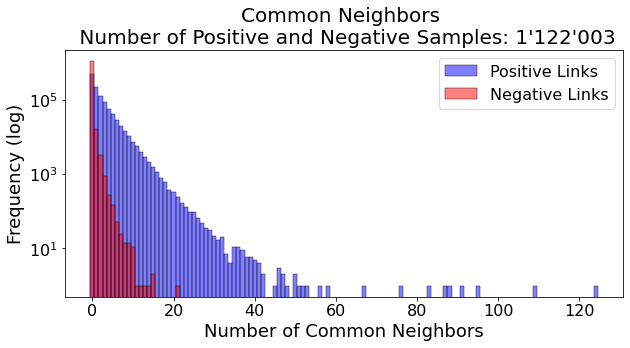

In [84]:

plt.figure(figsize=(10, 10))

plt.subplot(2, 1, 1)
sns.histplot(positive_common_neighbors, bins=np.arange(0, max(positive_common_neighbors)+2)-0.5, color='blue', kde=False, stat='count', label='Positive Links', alpha=0.5)
sns.histplot(negative_common_neighbors, bins=np.arange(0, max(negative_common_neighbors)+2)-0.5, color='red', kde=False, stat='count', label='Negative Links', alpha=0.5)
plt.xlabel('Number of Common Neighbors')
plt.yscale("log")
plt.ylabel('Frequency (log)')
plt.title(f'Common Neighbors \n Number of Positive and Negative Samples: {replace_number(len(positive_common_neighbors))}')
plt.legend()
plt.xticks(np.arange(min(positive_common_neighbors + negative_common_neighbors), max(positive_common_neighbors + negative_common_neighbors)+1, 20))

plt.savefig('eda_common_neighbour.pdf', format='pdf',dpi=5000,bbox_inches='tight')

plt.show()

**Observation and interpretation:** The distributions are clearly different. It can therefore be assumed that common neighbors function as a baseline. Nevertheless, there is a large proportion with very few common neighbors. Therefore, the common neighbor model will not perform well.

### Similarity distributions

**Explanation:** 
The distribution of cosine similarities of the Word2vec features is examined. Edges that actually exist are compared with edges that were randomly selected and do not exist.


**Why was the calculation made:**
There is a first understanding of the influence of the features. If a paper cites another paper, it should also be more similar in terms of features to a random paper. In addition, this also provides a basis for qualitatively examining the later results. It is therefore investigated whether the similarity values of a paper that cites another paper are lower than those of a random paper. This should be the case for both data sets.

In [24]:
half_the_edges = random.sample(list(range(train_edges_2.T.shape[0])),k = train_edges_2.T.shape[0]//2)

In [25]:
node_similarities,node_similarities_random = calc_similarities(dataset[0],nx_graph,train_edges.T)
node_similarities2,node_similarities_random2 = calc_similarities(dataset_2[0],nx_graph_2,train_edges_2.T[half_the_edges])
df1 = pd.DataFrame({'Kosinusähnlichkeit': node_similarities, 'Typ': 'Positive Links', 'Graph': 'CS'})
df2 = pd.DataFrame({'Kosinusähnlichkeit': node_similarities_random, 'Typ': 'Random Selected Links', 'Graph': 'CS'})
df3 = pd.DataFrame({'Kosinusähnlichkeit': node_similarities2, 'Typ': 'Positive Links', 'Graph': 'Arxiv w/o CS'})
df4 = pd.DataFrame({'Kosinusähnlichkeit': node_similarities_random2, 'Typ': 'Random Selected Links', 'Graph': 'Arxiv w/o CS'})

# Concatenate all dataframes into a single one
df_cosine = pd.concat([df1, df2, df3, df4])


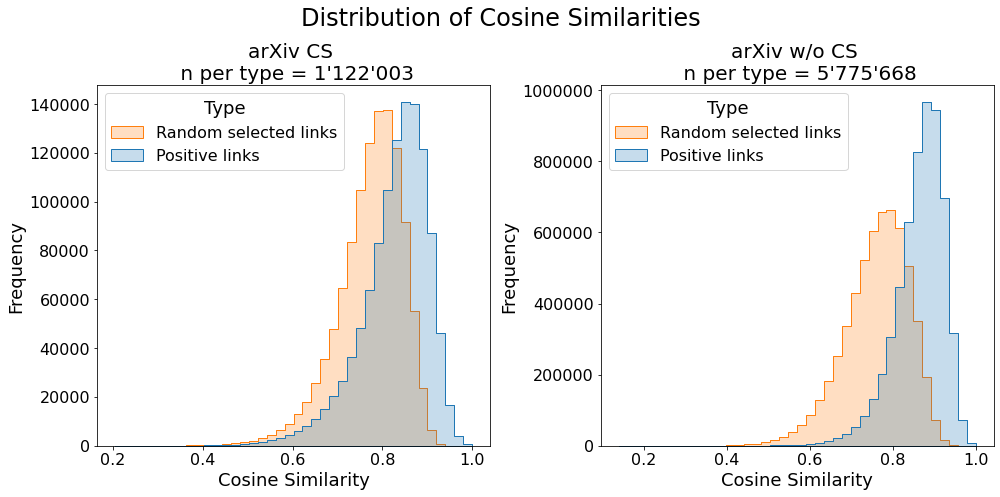

In [87]:
plt.figure(figsize=(14, 7))
plt.suptitle("Distribution of Cosine Similarities",fontsize = 24)
# Plot for the first graph
ax = plt.subplot(1, 2, 1)
sns.histplot(data=df_cosine[df_cosine['Graph'] == 'CS'], x='Kosinusähnlichkeit', hue='Typ', element='step', stat='count', common_bins=True, bins=40, ax=ax)
ax.set_title(f'{dataset.name} \n n per type = {replace_number(len(node_similarities))}')
ax.set_ylabel('Frequency')
ax.set_xlabel("Cosine Similarity")
ax.legend(loc='upper left',labels = ["Random selected links","Positive links"], title='Type')

# Plot for the second graph
ax2 = plt.subplot(1, 2, 2)
sns.histplot(data=df_cosine[df_cosine['Graph'] == 'Arxiv w/o CS'], x='Kosinusähnlichkeit', hue='Typ', element='step', stat='count', common_bins=True, bins=40, ax=ax2)
ax2.set_title(f'{dataset_2.name} \n n per type = {replace_number(len(node_similarities2))}')
ax2.set_ylabel('Frequency')
ax2.set_xlabel("Cosine Similarity")
ax2.ticklabel_format(style='plain', axis='y')
ax2.legend(loc='upper left',labels = ["Random selected links","Positive links"] , title='Type')

plt.tight_layout()
plt.savefig('eda_cosine_similarity.pdf', format='pdf',bbox_inches='tight')

plt.show()

**Observation and interpretation:** It can be confirmed that the similarity values of a paper that cites another paper are lower than for a random paper. It is also interesting to see that the differences in the arXiv w/o CS data set are greater. This could be due to the fact that the different research fields are further apart than computer science itself.

In order to keep this more similar, the negative samples could be selected only or increasingly within the same research group during pre-training.

## Evaluation
In the following, we will examine what different evaluation options are available and which one we choose.

In [ ]:
# ausführen
graph, label = dataset[0]
label = label.reshape(-1)

### MDS

In [ ]:
from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS

node_feat = graph["node_feat"]

edges = graph["edge_index"]

choice_2 = None
while choice_2 == None:
    try:
        choice = random.choice(range(1,len(node_feat)))
        choice_2 = random.choice(edges[1][edges[0] == choice])
        node_features = node_feat[[choice_2,choice] + list(edges[1][edges[0] == choice_2]) + list(edges[1][edges[0] == choice])]
        high_dim_cosine_distances = pairwise_distances(node_features, metric='cosine')
        mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
        low_dimensional_data = mds.fit_transform(high_dim_cosine_distances)
        low_dim_cosine_distances = pairwise_distances(low_dimensional_data, metric='euclidean')
        print(np.abs(low_dim_cosine_distances.ravel() - high_dim_cosine_distances.ravel()).sum()/len(high_dim_cosine_distances.ravel()))
    except:
        choice_2 = None

0.03168295425571328


In [ ]:


node_feat = graph["node_feat"]

edges = graph["edge_index"]
mean_distances = []
choice_2 = None
for x in range(node_feat.shape[0]):
    try:
        choice = random.choice(range(1,len(node_feat)))
        choice_2 = random.choice(edges[1][edges[0] == choice])
        node_features = node_feat[[choice_2,choice] + list(edges[1][edges[0] == choice_2]) + list(edges[1][edges[0] == choice])]
        high_dim_cosine_distances = pairwise_distances(node_features, metric='cosine')
        mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
        low_dimensional_data = mds.fit_transform(high_dim_cosine_distances)
        low_dim_cosine_distances = pairwise_distances(low_dimensional_data, metric='euclidean')
        mean_distances.append(np.abs(low_dim_cosine_distances.ravel() - high_dim_cosine_distances.ravel()).sum()/len(high_dim_cosine_distances.ravel()))
    except:
        choice_2 = None

c:\Users\User\.virtualenvs\link-prediction-in-graphs-YgTRKrde\Lib\site-packages\sklearn\manifold\_mds.py:165: RuntimeWarning: divide by zero encountered in scalar divide
  old_stress = stress / dis
c:\Users\User\.virtualenvs\link-prediction-in-graphs-YgTRKrde\Lib\site-packages\sklearn\manifold\_mds.py:161: RuntimeWarning: invalid value encountered in scalar divide
  if (old_stress - stress / dis) < eps:
c:\Users\User\.virtualenvs\link-prediction-in-graphs-YgTRKrde\Lib\site-packages\sklearn\manifold\_mds.py:165: RuntimeWarning: invalid value encountered in scalar divide
  old_stress = stress / dis
c:\Users\User\.virtualenvs\link-prediction-in-graphs-YgTRKrde\Lib\site-packages\sklearn\manifold\_mds.py:161: RuntimeWarning: invalid value encountered in scalar divide
  if (old_stress - stress / dis) < eps:
c:\Users\User\.virtualenvs\link-prediction-in-graphs-YgTRKrde\Lib\site-packages\sklearn\manifold\_mds.py:165: RuntimeWarning: invalid value encountered in scalar divide
  old_stress = str

### UMAP

In [ ]:
n_neighbours_for_umap = np.array(range(10, 401, 30))
min_dist_for_umap = np.array(range(0, 31, 5)) / 100

node_features = graph["node_feat"]

for n_neighbors in n_neighbours_for_umap:
    for min_dist in min_dist_for_umap:
        reducer = umap.UMAP(n_neighbors=n_neighbors, n_components=2, metric='cosine', min_dist=min_dist)
        reducer.fit(node_features)
        model_filename = f'./models_saved/umap_model_n_neighbors_{n_neighbors}_min_dist_{min_dist}.joblib'
        dump(reducer, model_filename)
        print(f"Saved UMAP model with n_neighbors={n_neighbors}, min_dist={min_dist}")

Saved UMAP model with n_neighbors=310, min_dist=0.0
Saved UMAP model with n_neighbors=310, min_dist=0.05
Saved UMAP model with n_neighbors=310, min_dist=0.1
Saved UMAP model with n_neighbors=310, min_dist=0.15
Saved UMAP model with n_neighbors=340, min_dist=0.0
Saved UMAP model with n_neighbors=340, min_dist=0.05
Saved UMAP model with n_neighbors=340, min_dist=0.1
Saved UMAP model with n_neighbors=340, min_dist=0.15
Saved UMAP model with n_neighbors=370, min_dist=0.0
Saved UMAP model with n_neighbors=370, min_dist=0.05
Saved UMAP model with n_neighbors=370, min_dist=0.1
Saved UMAP model with n_neighbors=370, min_dist=0.15
Saved UMAP model with n_neighbors=400, min_dist=0.0
Saved UMAP model with n_neighbors=400, min_dist=0.05
Saved UMAP model with n_neighbors=400, min_dist=0.1
Saved UMAP model with n_neighbors=400, min_dist=0.15


In [ ]:
reducer = load('./models_saved/umap_model_n_neighbors_400_min_dist_0.00.joblib')
embedding = reducer.transform(graph["node_feat"])

def plot_nodes_in_umap_space(edges,plot_other_embeddings=True,embedding= embedding):
    edges = edges.T
    choice_2 = None
    while choice_2 == None:
        try:
            choice = random.choice(range(1,len(embedding)))
            choice_2 = random.choice(edges[1][edges[0] == choice])
        except:
            choice_2 = None

    embeddings_choice_1 = embedding[choice]
    embeddings_choice_2 = embedding[choice_2]

    fig, ax = plt.subplots()
    if plot_other_embeddings:
        ax.scatter(*zip(*embedding), color = [0,0,0.01,0.02], label ="other nodes", s = 0.5)

    if len(edges[1][edges[0] == choice_2]) != 0:
        embeddings_choice_2_neighbours = embedding[edges[1][edges[0] == choice_2]]
        ax.scatter(*zip(*embeddings_choice_2_neighbours), color='orange', label='Zitierte Paper des Endknotens', s=10)

    if len(edges[1][edges[0] == choice]) != 0:
        embeddings_choice_1_neighbours = embedding[edges[1][edges[0] == choice]]
        ax.scatter(*zip(*embeddings_choice_1_neighbours), color="blue", label='Zitierte Paper des Startknotens', s=10)

    ax.scatter(*embeddings_choice_1, color='green', label='Startknoten', s=70)
    ax.scatter(*embeddings_choice_2, color='red', label='Endknoten', s=70)
    ax.annotate('', xy=embeddings_choice_2, xytext=embeddings_choice_1, arrowprops=dict(arrowstyle="->", lw=2))
    ax.legend()
    plt.show()

### 7 Groups Categorization of Computer Science Fields
They could be divided into various groups. For the overview, the computer science fields have been divided into the following 7 groups.

**1. Theoretical Computer Science and Mathematics**

   - Logic in Computer Science
   - Computational Complexity
   - Discrete Mathematics
   - Formal Languages and Automata Theory
   - Symbolic Computation

**2. Artificial Intelligence and Machine Learning**

   - Artificial Intelligence
   - Machine Learning
   - Neural and Evolutionary Computing
   - Computer Vision and Pattern Recognition
   - Multiagent Systems
   - Robotics

**3. Software and Systems**

   - Distributed, Parallel, and Cluster Computing
   - Operating Systems
   - Programming Languages
   - Software Engineering
   - Systems and Control
   - Hardware Architecture
   - Performance

**4. Data, Information, and Security**

   - Numerical Analysis
   - Cryptography and Security
   - Databases
   - Data Structures and Algorithms
   - Information Retrieval
   - Information Theory
   - Mathematical Software

**5. Network and Society**

   - Computers and Society
   - Networking and Internet Architecture
   - Social and Information Networks
   - Computer Science and Game Theory

**6. Human-Centered and Interactive Computing**

   - Human-Computer Interaction
   - Graphics
   - Multimedia
   - Sound
   - Emerging Technologies

**7. Computational Applications**

   - Computational Engineering, Finance, and Science
   - Computational Geometry
   - Digital Libraries
   - General Literature


In [ ]:
# ausführen
file_path = "./dataset/ogbn_arxiv/mapping/labelidx2arxivcategeory.csv.gz"
labelidx2arxivcategeory = pd.read_csv(file_path, compression='gzip')
categories_info = [
    ["arxiv cs na", "Numerical Analysis", "Data, Information, and Security"],
    ["arxiv cs mm", "Multimedia", "Human-Centered and Interactive Computing"],
    ["arxiv cs lo", "Logic in Computer Science", "Theoretical Computer Science and Mathematics"],
    ["arxiv cs cy", "Computers and Society", "Network and Society"],
    ["arxiv cs cr", "Cryptography and Security", "Data, Information, and Security"],
    ["arxiv cs dc", "Distributed, Parallel, and Cluster Computing", "Software and Systems"],
    ["arxiv cs hc", "Human-Computer Interaction", "Human-Centered and Interactive Computing"],
    ["arxiv cs ce", "Computational Engineering, Finance, and Science", "Computational Applications"],
    ["arxiv cs ni", "Networking and Internet Architecture", "Network and Society"],
    ["arxiv cs cc", "Computational Complexity", "Theoretical Computer Science and Mathematics"],
    ["arxiv cs ai", "Artificial Intelligence", "Artificial Intelligence and Machine Learning"],
    ["arxiv cs ma", "Multiagent Systems", "Artificial Intelligence and Machine Learning"],
    ["arxiv cs gl", "General Literature", "Computational Applications"],
    ["arxiv cs ne", "Neural and Evolutionary Computing", "Artificial Intelligence and Machine Learning"],
    ["arxiv cs sc", "Symbolic Computation", "Theoretical Computer Science and Mathematics"],
    ["arxiv cs ar", "Hardware Architecture", "Software and Systems"],
    ["arxiv cs cv", "Computer Vision and Pattern Recognition", "Artificial Intelligence and Machine Learning"],
    ["arxiv cs gr", "Graphics", "Human-Centered and Interactive Computing"],
    ["arxiv cs et", "Emerging Technologies", "Human-Centered and Interactive Computing"],
    ["arxiv cs sy", "Systems and Control", "Software and Systems"],
    ["arxiv cs cg", "Computational Geometry", "Computational Applications"],
    ["arxiv cs oh", "Other Computer Science", "Human-Centered and Interactive Computing"],  # Adjusted as a placeholder
    ["arxiv cs pl", "Programming Languages", "Software and Systems"],
    ["arxiv cs se", "Software Engineering", "Software and Systems"],
    ["arxiv cs lg", "Machine Learning", "Artificial Intelligence and Machine Learning"],
    ["arxiv cs sd", "Sound", "Human-Centered and Interactive Computing"],
    ["arxiv cs si", "Social and Information Networks", "Network and Society"],
    ["arxiv cs ro", "Robotics", "Artificial Intelligence and Machine Learning"],
    ["arxiv cs it", "Information Theory", "Data, Information, and Security"],
    ["arxiv cs pf", "Performance", "Software and Systems"],
    ["arxiv cs cl", "Computation and Language", "Data, Information, and Security"],
    ["arxiv cs ir", "Information Retrieval", "Data, Information, and Security"],
    ["arxiv cs ms", "Mathematical Software", "Data, Information, and Security"],
    ["arxiv cs fl", "Formal Languages and Automata Theory", "Theoretical Computer Science and Mathematics"],
    ["arxiv cs ds", "Data Structures and Algorithms", "Data, Information, and Security"],
    ["arxiv cs os", "Operating Systems", "Software and Systems"],
    ["arxiv cs gt", "Computer Science and Game Theory", "Network and Society"],
    ["arxiv cs db", "Databases", "Data, Information, and Security"],
    ["arxiv cs dl", "Digital Libraries", "Computational Applications"],
    ["arxiv cs dm", "Discrete Mathematics", "Theoretical Computer Science and Mathematics"]
]
categories_df = pd.DataFrame(categories_info, columns=['arxiv category', 'full_name', 'group_title'])

# Merging the DataFrames on the 'arxiv_category' column
categories_with_group = pd.merge(labelidx2arxivcategeory, categories_df, on='arxiv category', how='left')

In [ ]:
# ausführen
def visualize_all_groups_umap(embeddings, categories_with_group, label,alpha, groups_to_plot=None):
    if groups_to_plot is None:
        groups_to_plot = categories_with_group["group_title"].unique()
    
    # Filter categories to include only those in the specified groups to plot
    filtered_categories = categories_with_group[categories_with_group["group_title"].isin(groups_to_plot)]
    
    # Unique labels for each plot level
    unique_group_labels = np.unique(filtered_categories["group_title"])
    unique_full_name_labels = np.unique(filtered_categories["full_name"])
    
    # Create color maps for each unique label set
    colors_group = plt.cm.rainbow(np.linspace(0, 1, len(unique_group_labels)))
    colors_full_name = plt.cm.Set3(np.linspace(0, 1, len(unique_full_name_labels)))
    
    # Map labels to colors
    label_to_color_group = dict(zip(unique_group_labels, colors_group))
    label_to_color_full_name = dict(zip(unique_full_name_labels, colors_full_name))
    
    fig, axs = plt.subplots(2, 1, figsize=(15, 15))

    added_labels_group = set()
    added_labels_fullname = set()

    for label_i in np.unique(label):
        idx = label == label_i
        category_info = categories_with_group.loc[categories_with_group['label idx'] == label_i]
        group_title = category_info['group_title'].values[0]
        full_name = category_info['full_name'].values[0]

        # Plot only the selected groups for group_title
        if group_title in groups_to_plot:
            if group_title not in added_labels_group:
                axs[0].scatter(embeddings[idx, 0], embeddings[idx, 1], s=0.05, color=label_to_color_group[group_title], label=group_title, alpha=alpha)
                added_labels_group.add(group_title)
            else:
                axs[0].scatter(embeddings[idx, 0], embeddings[idx, 1], s=0.05, color=label_to_color_group[group_title], alpha=alpha)

            # Plot only the selected groups for full_name
            if full_name not in added_labels_fullname:
                axs[1].scatter(embeddings[idx, 0], embeddings[idx, 1], s=0.05, color=label_to_color_full_name[full_name], label=f"{full_name} n: {idx.sum()}", alpha=alpha)
                added_labels_fullname.add(full_name)
            else:
                axs[1].scatter(embeddings[idx, 0], embeddings[idx, 1], s=0.05, color=label_to_color_full_name[full_name], alpha=alpha)

    axs[0].legend(markerscale=30, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    axs[0].set_title('Group Title Visualization')
    axs[1].legend(markerscale=30, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    axs[1].set_title('Full Name Visualization')
    plt.show()


IntSlider(value=10, continuous_update=False, description='Neighbors:', max=400, min=10, step=30)

FloatSlider(value=0.0, continuous_update=False, description='Min Dist:', max=0.3, step=0.05)

FloatSlider(value=0.3, continuous_update=False, description='Transparency:', max=1.0, min=0.05, step=0.05)

Button(description='Update Plot', style=ButtonStyle())

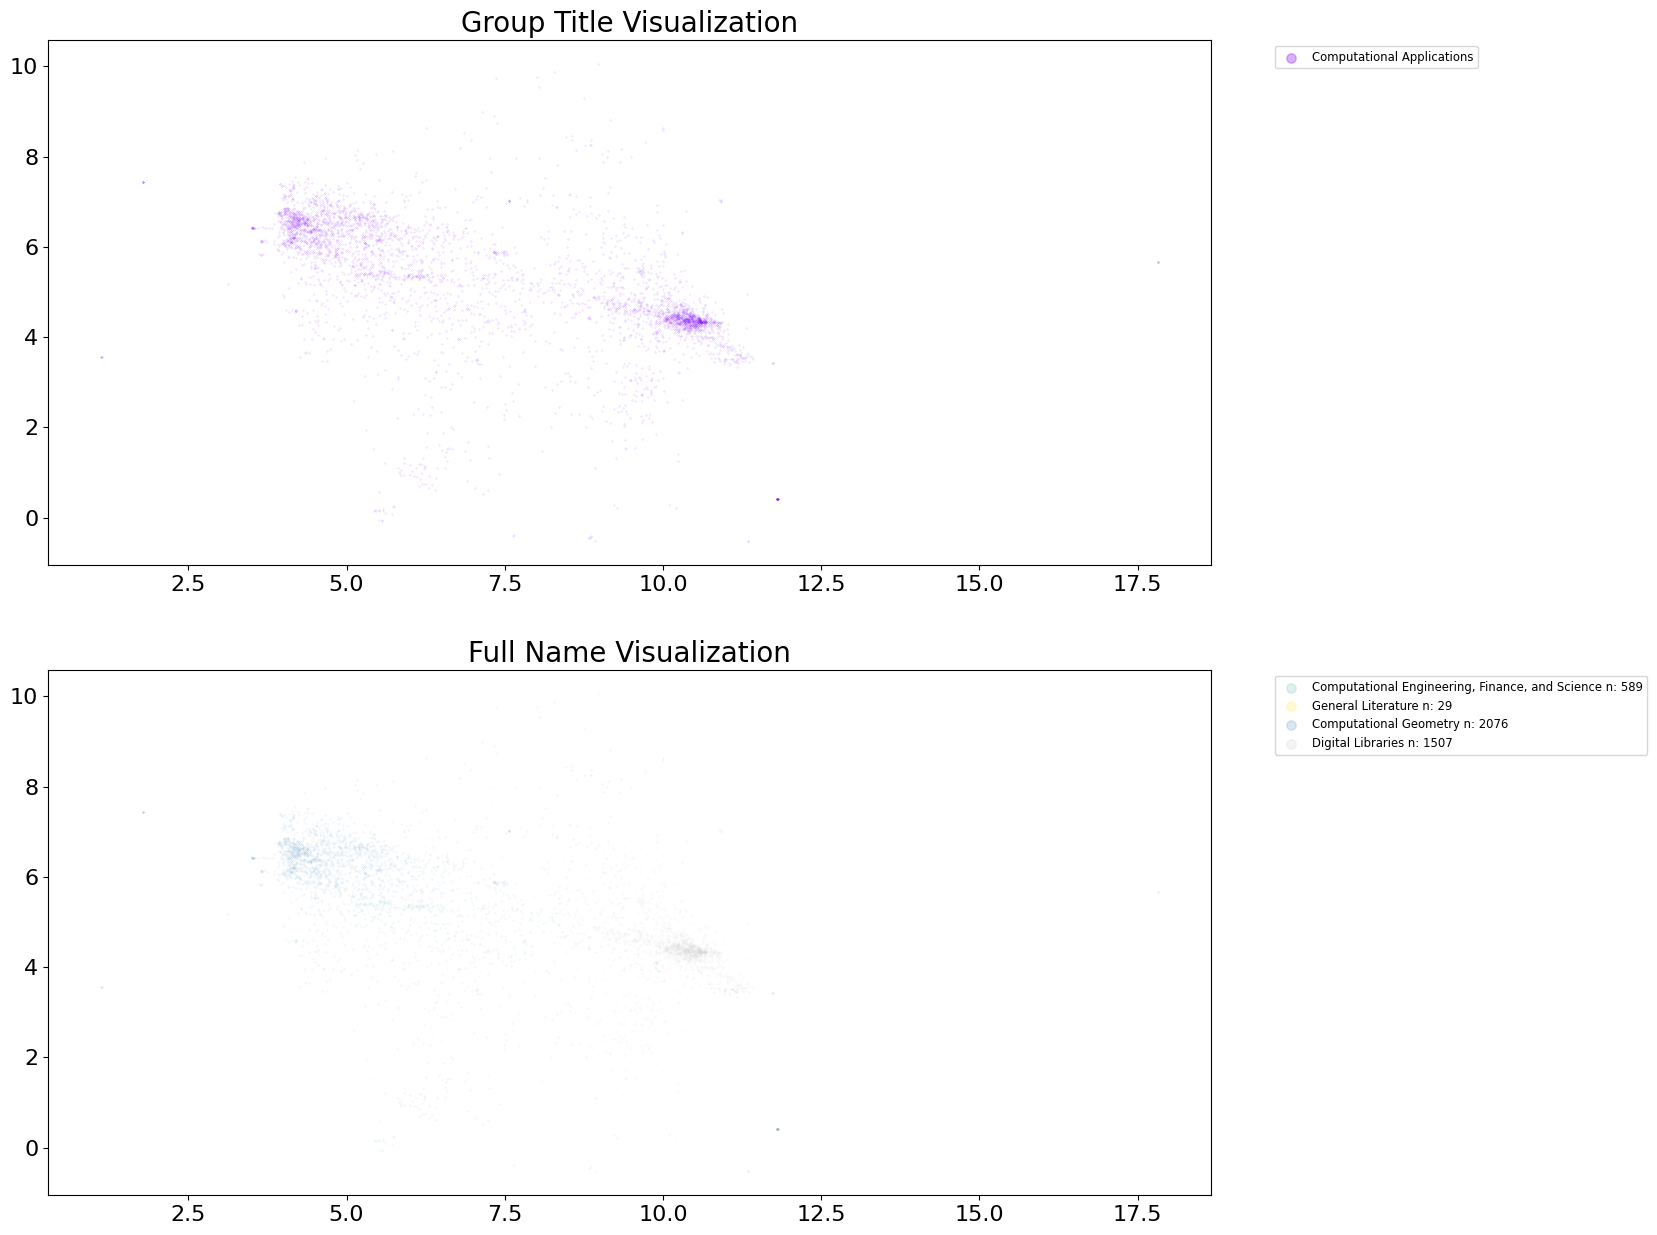

In [ ]:
# ausführen
n_neighbours_for_umap = np.array(range(10, 401, 30))
min_dist_for_umap = np.array(range(0, 31, 5)) / 100

def load_and_visualize(n_neighbors, min_dist, groups_to_plot,alpha):
    model_filename = f'./models_saved/umap_model_n_neighbors_{n_neighbors}_min_dist_{min_dist:.2f}.joblib'
    reducer = load(model_filename)
    embeddings = reducer.embedding_
    # It's assumed visualize_all_groups_umap handles the plotting
    visualize_all_groups_umap(embeddings, categories_with_group, label,alpha, groups_to_plot)


alpha_slider = widgets.FloatSlider(
    value=0.3,
    min=0.05,
    max=1.0,
    step=0.05,
    description='Transparency:',
    continuous_update=False
)
# Set up your sliders
n_neighbors_slider = widgets.IntSlider(
    value=10,
    min=min(n_neighbours_for_umap),
    max=max(n_neighbours_for_umap),
    step=n_neighbours_for_umap[1] - n_neighbours_for_umap[0], 
    description='Neighbors:',
    continuous_update=False
)

min_dist_slider = widgets.FloatSlider(
    value=0.00,
    min=min(min_dist_for_umap),
    max=max(min_dist_for_umap),
    step=min_dist_for_umap[1] - min_dist_for_umap[0],
    description='Min Dist:',
    continuous_update=False
)

# Create checkbox widgets for group titles
checkbox_widgets = [widgets.Checkbox(value=True, description=str(group)) for group in categories_with_group["group_title"].unique()]
checkbox_container = widgets.VBox(checkbox_widgets)

# A button to trigger the update
update_button = widgets.Button(description="Update Plot")

def update_plot(b):
    clear_output(wait=True)  # Clear the current output including widgets to prevent flickering
    display(n_neighbors_slider, min_dist_slider, alpha_slider, checkbox_container, update_button)  # Redisplay the widgets
    selected_groups = [cb.description for cb in checkbox_widgets if cb.value]
    load_and_visualize(n_neighbors_slider.value, min_dist_slider.value, selected_groups, alpha_slider.value)

# Assign the button event
update_button.on_click(update_plot)

# Display the widgets
display(n_neighbors_slider, min_dist_slider, alpha_slider, checkbox_container, update_button)

(32, 2)


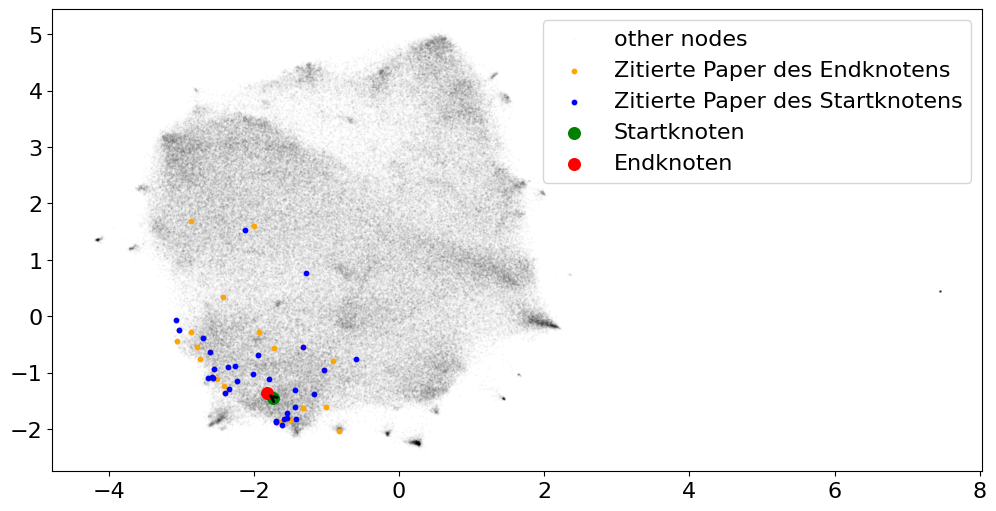

In [ ]:
plot_nodes_in_umap_space(plot_other_embeddings=True,edges=graph["edge_index"].T)

## Further thoughts

Here are things we wanted to check but are otherwise in an unstructured form.

In [ ]:
nx_graph = nx.DiGraph()
# Assuming graph["node_feat"] and graph["edge_index"] are already defined
nx_graph.add_nodes_from(range(len(graph["node_feat"])))
nx_graph.add_edges_from(graph["edge_index"].T)

# Finding components
strong_component_sizes_out = [len(c) for c in nx.strongly_connected_components(nx_graph)]
values = np.array(list(nx.strongly_connected_components(nx_graph)))[np.array(strong_component_sizes_out) != 1]

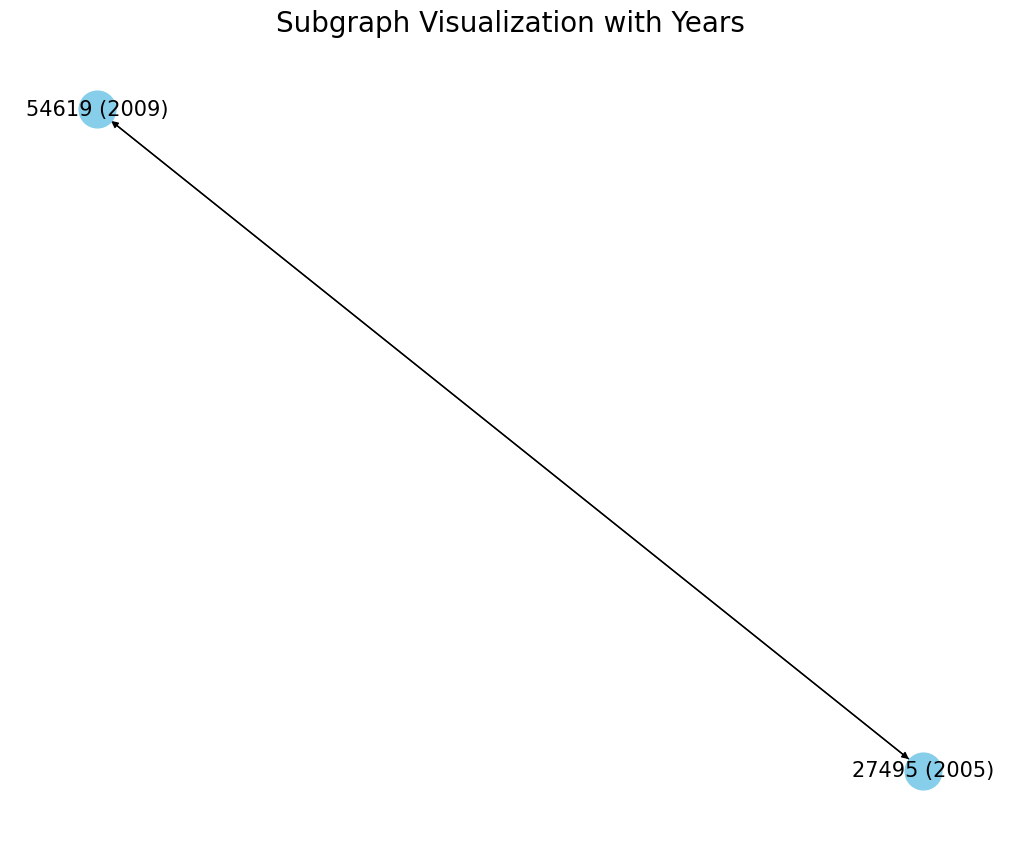

In [ ]:
nodes_to_plot = values[60]

# Create a subgraph with the nodes of interest
subgraph = nx_graph.subgraph(nodes_to_plot)

# Prepare node labels with years
node_years = graph["node_year"].flatten()
node_labels = {node: f'{node} ({node_years[node]})' for node in subgraph.nodes()}

# Plotting
plt.figure(figsize=(10, 8))
nx.draw(subgraph, with_labels=True, labels=node_labels, node_color='skyblue', node_size=700, edge_color='k', linewidths=1, font_size=15)
plt.title('Subgraph Visualization with Years')
plt.show()
